In [1]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
output_begin = 4
num_outputs = 1

In [65]:
timesteps = 16 # TimeseriesGenerator Handles overlapping
learning_rate = 0.00001
in_epochs = 1
out_epochs = 5
train_batch_size = 15
test_batch_size = 10

In [66]:
subjectList = [1, 2, 3, 4, 5, 7, 8, 11, 12, 14] # except [6, 13, 10, ]
testSubjects = [9]

In [67]:
num_datasets = len(subjectList)

In [69]:
def getFinalModel(num_outputs = num_outputs):
    inp = (224, 224, 3) # BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', input_shape = inp, include_top=False) #BIWI_Frame_Shape
    """"
    vgg_model.layers.pop()
    vgg_model.outputs = [vgg_model.layers[-1].output]#
    vgg_model.output_layers = [vgg_model.layers[-1]]#
    vgg_model.layers[-1].outbound_nodes = []#
    """
    nb_pretrained_layers = len(vgg_model.layers)
    for layer in vgg_model.layers: #
        layer.trainable = False#
    #print(nb_pretrained_layers)
    #vgg_model.summary()
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2]), name = 'tdVGG16')) 
    rnn.add(TimeDistributed(Flatten()))
    
    """
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc1024'))#, activation='relu'
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(4096, activation='relu'), name = 'fc104'))   # 
    rnn.add(TimeDistributed(Dropout(0.25)))#
    rnn.add(TimeDistributed(Dense(1024, activation='relu'), name = 'fc10'))#
    rnn.add(TimeDistributed(Dropout(0.25)))
    """

    rnn.add(LSTM(128, dropout=0.25, recurrent_dropout=0.25)) #
   # rnn.add(Flatten())
    rnn.add(Dense(num_outputs))
    #print(len(rnn.layers))
    for layer in rnn.layers[:1]:#
        layer.trainable = False#
    adam = optimizers.Adam(lr=learning_rate)
    rnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])
    return rnn

In [70]:
keras.backend.clear_session()#
full_model = getFinalModel(num_outputs = num_outputs)

In [71]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tdVGG16 (TimeDistributed)    (None, 16, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 25088)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               12911104  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 27,625,921
Trainable params: 12,911,233
Non-trainable params: 14,714,688
_________________________________________________________________


In [72]:
full_model = trainImageModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 10 datasets have been read by 2019-01-11 02:27:06.041266
1. set (Dataset 12) being trained for epoch 1!
Epoch 1/1
48/48 [==============================] - 55s 1s/step - loss: 0.3130 - mean_absolute_error: 0.4431
2. set (Dataset 3) being trained for epoch 1!
Epoch 1/1
48/48 [==============================] - 51s 1s/step - loss: 0.3023 - mean_absolute_error: 0.4343
3. set (Dataset 1) being trained for epoch 1!
Epoch 1/1
33/33 [==============================] - 33s 1s/step - loss: 0.3207 - mean_absolute_error: 0.4569
4. set (Dataset 11) being trained for epoch 1!
Epoch 1/1
38/38 [==============================] - 38s 1s/step - loss: 0.2411 - mean_absolute_error: 0.3948
5. set (Dataset 8) being trained for epoch 1!
Epoch 1/1
51/51 [==============================] - 51s 1s/step - loss: 0.2363 - mean_absolute_error: 0.3917
6. set (Dataset 14) being trained for epoch 1!
Epoch 1/1
53/53 [==============================] - 53s 1s/step - loss: 0.1996 - mean_absolut

33/33 [==============================] - 33s 993ms/step - loss: 0.0663 - mean_absolute_error: 0.2074
Epoch 5 completed!


In [73]:
test_generators, test_labelSets = getTestBiwiForImageModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] #[1]

All frames and annotations from 1 datasets have been read by 2019-01-11 03:12:27.455243


In [74]:
predictions = full_model.predict_generator(test_gen, verbose = 1)
#predictions = full_model.predict(test_gen[0][0], verbose = 1)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

87/87 [==============================] - 56s 649ms/step


In [75]:
print([i[0] for i in predictions[:10]])

[-0.13305277, -0.11302185, -0.13421702, -0.10153634, -0.16614397, -0.1558722, -0.18292229, -0.15296501, -0.18125036, -0.11927018]


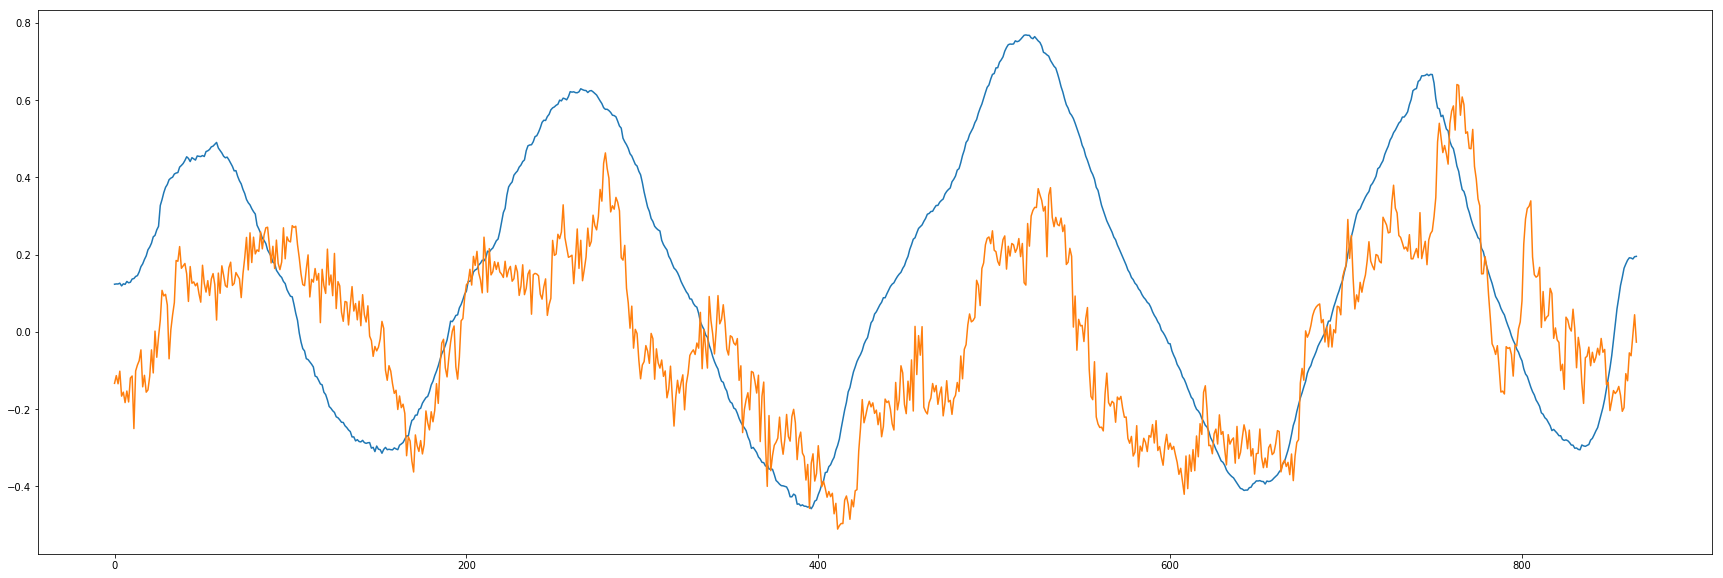

In [76]:
plt.figure(figsize=(30,10))
plt.plot(output1)

In [ ]:
exit()